# CARREGAR A BASE DE DADOS (ARQUIVOS NPY)

                     filename  \
0  SBBE_2015-08-08_E6_100.png   
1  SBBE_2015-08-08_E6_110.png   
2  SBBE_2015-08-08_E6_120.png   
3  SBBE_2015-08-08_E6_130.png   
4  SBBE_2015-08-08_E6_140.png   

                                               image  clusters  
0  [[[0.3764705882352941, 0.42745098039215684, 0....         3  
1  [[[0.19607843137254902, 0.24313725490196078, 0...         3  
2  [[[0.3568627450980392, 0.38823529411764707, 0....         3  
3  [[[0.28627450980392155, 0.34509803921568627, 0...         3  
4  [[[0.2823529411764706, 0.30980392156862746, 0....         3  


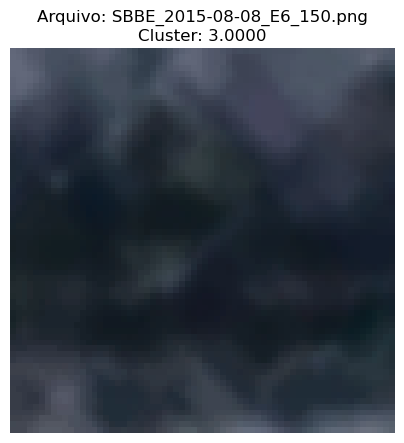

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para os arquivos .npy
images_file_path = r'C:\Users\silve\TESE\images_by_cluster_80.npy'
coefs_file_path = r'C:\Users\silve\TESE\clusters_80.npy'
filenames_file_path = r'C:\Users\silve\TESE\filenames_80.npy'  # Caminho para o arquivo com os nomes dos arquivos

# Carregar os arrays numpy dos arquivos .npy
images_array = np.load(images_file_path, allow_pickle=True)
coefs_array = np.load(coefs_file_path, allow_pickle=True)
filenames_array = np.load(filenames_file_path, allow_pickle=True)  # Carregar o array com os nomes dos arquivos

# Reconstruir o DataFrame incluindo a coluna de nomes de arquivos
df_images = pd.DataFrame({
    'filename': filenames_array,  # Adicionar os nomes dos arquivos como uma nova coluna
    'image': list(images_array),  # Converter o array de imagens para uma lista de arrays
    'clusters': coefs_array
})

# Exibir as primeiras linhas do DataFrame para confirmar a estrutura
print(df_images.head())

# Função para exibir uma imagem do DataFrame, seu coeficiente e o nome do arquivo
def display_image_and_cluster(df, index):
    # Verificar se o índice é válido
    if index < 0 or index >= len(df):
        print("Índice fora do intervalo.")
        return

    # Acessar a imagem, o coeficiente e o nome do arquivo
    image_array = df.at[index, 'image']
    cluster = df.at[index, 'clusters']
    filename = df.at[index, 'filename']

    # Configurar a figura
    plt.figure(figsize=(5, 5))

    # Exibir a imagem
    plt.imshow(image_array)
    plt.axis('off')  # Desligar os eixos para uma visualização mais clara

    # Exibir o coeficiente de cluster e o nome do arquivo como título
    plt.title(f'Arquivo: {filename}\nCluster: {cluster:.4f}', fontsize=12)

    # Mostrar a figura
    plt.show()

# Exemplo de uso da função para exibir a imagem no índice 5, seu coeficiente e o nome do arquivo
display_image_and_cluster(df_images, 5)


# CRIAÇÃO DOS GRUPOS DE TREINO, VALIDAÇÃO E TESTE

In [2]:
from sklearn.model_selection import train_test_split

# Dividir o DataFrame em conjunto de treino e teste
train_df, test_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Dividir o conjunto de treino para criar o conjunto de validação
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Tamanho do conjunto de treino: {len(train_df)}')
print(f'Tamanho do conjunto de validação: {len(val_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

# Função para preparar os dados, incluindo os filenames
def prepare_data(df):
    """Extrai imagens, clusters e filenames do DataFrame e os converte em arrays numpy."""
    images = np.array(list(df['image']))  # Listar e converter para array numpy
    clusters = np.array(df['clusters'])
    filenames = df['filename'].to_numpy()  # Converter a coluna de filenames para array numpy
    return images, clusters, filenames

# Preparar os dados para treino, validação e teste
X_train, y_train, filenames_train = prepare_data(train_df)
X_val, y_val, filenames_val = prepare_data(val_df)
X_test, y_test, filenames_test = prepare_data(test_df)

print(f'Forma das imagens de treino: {X_train.shape}')
print(f'Forma dos clusters de treino: {y_train.shape}')
print(f'Forma dos filenames de treino: {filenames_train.shape}')
print(f'Forma das imagens de validação: {X_val.shape}')
print(f'Forma dos clusters de validação: {y_val.shape}')
print(f'Forma dos filenames de validação: {filenames_val.shape}')
print(f'Forma das imagens de teste: {X_test.shape}')
print(f'Forma dos clusters de teste: {y_test.shape}')
print(f'Forma dos filenames de teste: {filenames_test.shape}')


Tamanho do conjunto de treino: 16425
Tamanho do conjunto de validação: 5476
Tamanho do conjunto de teste: 5476
Forma das imagens de treino: (16425, 66, 66, 3)
Forma dos clusters de treino: (16425,)
Forma dos filenames de treino: (16425,)
Forma das imagens de validação: (5476, 66, 66, 3)
Forma dos clusters de validação: (5476,)
Forma dos filenames de validação: (5476,)
Forma das imagens de teste: (5476, 66, 66, 3)
Forma dos clusters de teste: (5476,)
Forma dos filenames de teste: (5476,)


# PROCESSAMENTO DO MODELO

## OTIMIZAÇÃO DOS HIPERPARÂMETROS

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
import os
import shutil
import numpy as np

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Prompt para o usuário
reset = input("Deseja resetar as informações da última rodada e iniciar uma nova otimização? (s/n): ")

tuner_dir = '10_cnn_80'  # Caminho para o diretório do Keras Tuner

if reset.lower() == 's':
    if os.path.exists(tuner_dir):
        shutil.rmtree(tuner_dir)  # Remove o diretório e todo o seu conteúdo
        print("Informações da última rodada resetadas. Iniciando nova otimização...")

    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory=tuner_dir,
        project_name='cnn_hyperparam_optimization'
    )

    tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

elif reset.lower() == 'n':
    # Inicializa o Keras Tuner para carregar os dados existentes
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory=tuner_dir,
        project_name='cnn_hyperparam_optimization'
    )
    # Carrega os melhores hiperparâmetros sem continuar a busca
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Constrói o modelo com os melhores hiperparâmetros
    model = build_model(best_hps)
    print("Modelo carregado com os melhores hiperparâmetros da última otimização.")

else:
    print("Entrada inválida. Por favor, responda com 's' para sim ou 'n' para não.")



Deseja resetar as informações da última rodada e iniciar uma nova otimização? (s/n): n
Reloading Tuner from 10_cnn_80\cnn_hyperparam_optimization\tuner0.json


Modelo carregado com os melhores hiperparâmetros da última otimização.


## RODANDO O MODELO DE ACORDO COM OS HIPERPARÂMETROS OTIMIZADOS

In [4]:
# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construa o modelo com os melhores hiperparâmetros
model = build_model(best_hps)

# Exibir a arquitetura do modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Definir a seed para reprodutibilidade
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Supondo que a função build_model e o objeto tuner já estejam definidos como anteriormente

# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construa o modelo com os melhores hiperparâmetros
model = build_model(best_hps)

# Defina o callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora a perda de validação
    patience=20,         # Número de épocas sem melhoria após o qual o treinamento será interrompido
    restore_best_weights=True  # Restaura os pesos do modelo com o melhor valor de perda de validação
)

# Certifique-se de que X_train, y_train, X_val, e y_val estão definidos e prontos para uso

# Treine o modelo com a seed definida
history = model.fit(
    X_train, y_train,
    epochs=20,  # Número máximo de épocas
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Inclui o callback de Early Stopping
    shuffle=True  # Garante que os batches sejam embaralhados de forma consistente
)

# Certifique-se de que X_test e y_test estão definidos e prontos para uso

# Opcional: Avalie o modelo no conjunto de teste após o treinamento
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/20


514/514 [==============================] - 18s 33ms/step - loss: 1.3853 - accuracy: 0.2774 - val_loss: 1.3829 - val_accuracy: 0.2810
Epoch 2/20
514/514 [==============================] - 16s 32ms/step - loss: 1.3826 - accuracy: 0.2843 - val_loss: 1.3798 - val_accuracy: 0.2825
Epoch 3/20
514/514 [==============================] - 16s 30ms/step - loss: 1.3806 - accuracy: 0.2841 - val_loss: 1.3784 - val_accuracy: 0.2869
Epoch 4/20
514/514 [==============================] - 16s 30ms/step - loss: 1.3782 - accuracy: 0.2915 - val_loss: 1.3740 - val_accuracy: 0.2960
Epoch 5/20
514/514 [==============================] - 16s 30ms/step - loss: 1.3734 - accuracy: 0.2936 - val_loss: 1.3741 - val_accuracy: 0.3015
Epoch 6/20
514/514 [==============================] - 16s 30ms/step - loss: 1.3683 - accuracy: 0.3003 - val_loss: 1.3643 - val_accuracy: 0.3150
Epoch 7/20
514/514 [==============================] - 16s 30ms/step - loss: 1.3622 - accuracy: 0.3078 - val_loss: 1.3597 - val_accurac

## INDICADORES DE PERFORMANCE DO MODELO

### PARÂMETROS NUMÉRICOS NO TESTE (PERDA, ACURÁCIA, PRECISÃO, RECALL E F1)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Avaliar o modelo no conjunto de validação
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)

# Previsões do modelo
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verificar se y_val é categórico e converter para classes se necessário
if y_val.ndim > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Acurácia
accuracy = accuracy_score(y_true, y_pred_classes)

# Precisão
precision = precision_score(y_true, y_pred_classes, average='macro')

# Recall
recall = recall_score(y_true, y_pred_classes, average='macro')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Imprimir os resultados
print(f"Perda no Teste: {test_loss}")
print(f"Acurácia no Teste: {test_acc}")
print("Matriz de Confusão:", conf_matrix, sep="\n")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"Pontuação F1: {f1}")


172/172 - 1s - loss: 1.3191 - accuracy: 0.3669 - 1s/epoch - 9ms/step
172/172 [==============================] - 2s 9ms/step
Perda no Teste: 1.3190829753875732
Acurácia no Teste: 0.3668736219406128
Matriz de Confusão:
[[579 461 100 295]
 [396 642 156 313]
 [258 372 216 368]
 [239 371 138 572]]
Precisão: 0.3661821943673832
Recall: 0.36018845390346915
Pontuação F1: 0.35425395213127714


### CURVA DE APRENDIZADO PERDA E ACURÁCIA

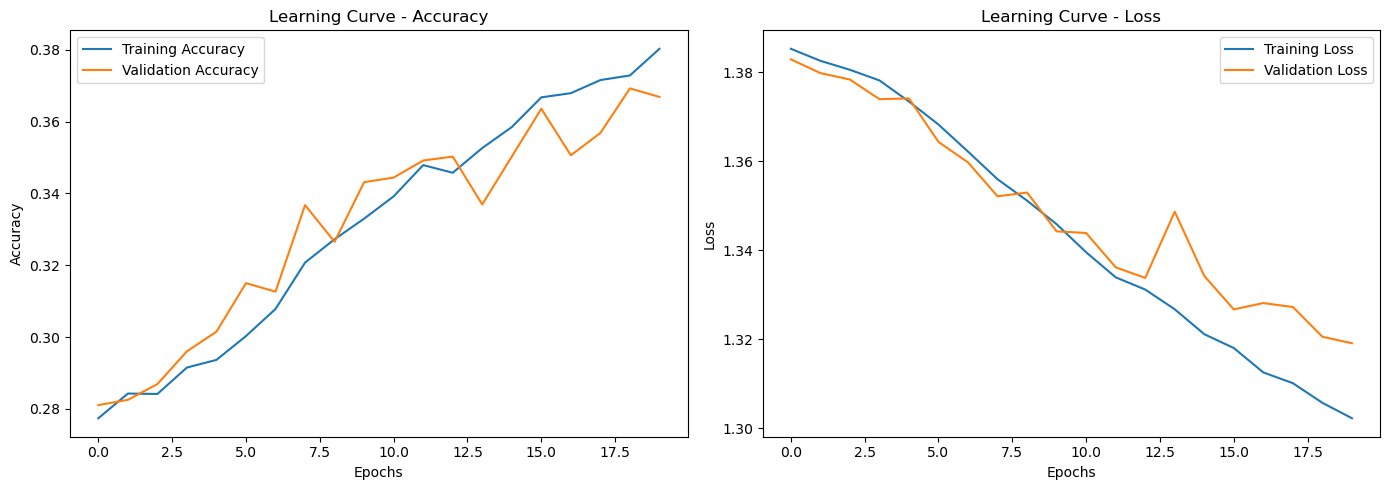

In [7]:
import matplotlib.pyplot as plt

# Plotting the learning curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### MATRIZ DE CONFUSÃO

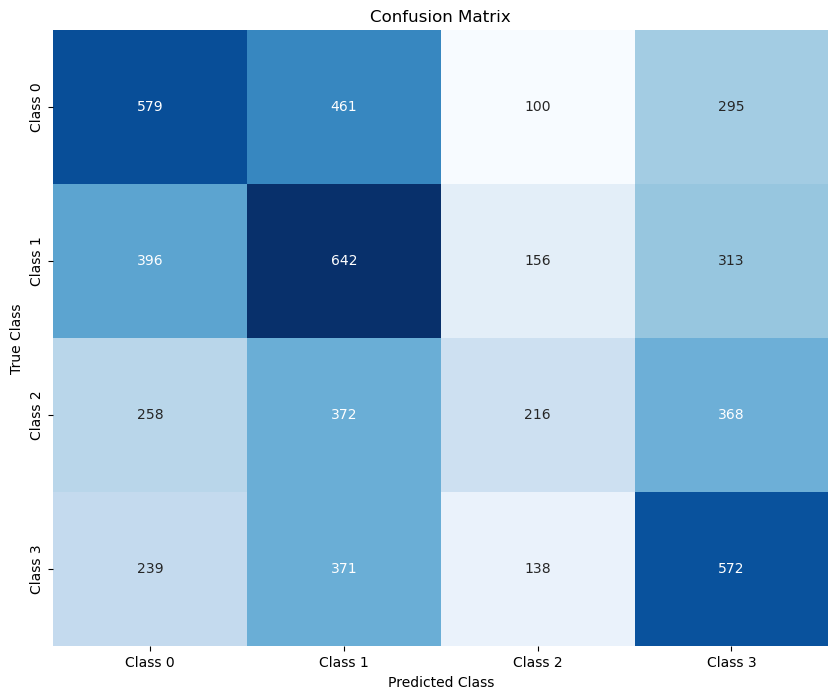

In [8]:
# CONFUSION MATRIX

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Insert your Confusion Matrix data here
confusion_mtx = conf_matrix  # Assuming conf_matrix is defined elsewhere

# Axis labels
axis_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Setting the figure size
plt.figure(figsize=(10, 8))

# Creating the heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

# Adding title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Displaying the plot
plt.show()


172/172 [==============================] - 2s 9ms/step


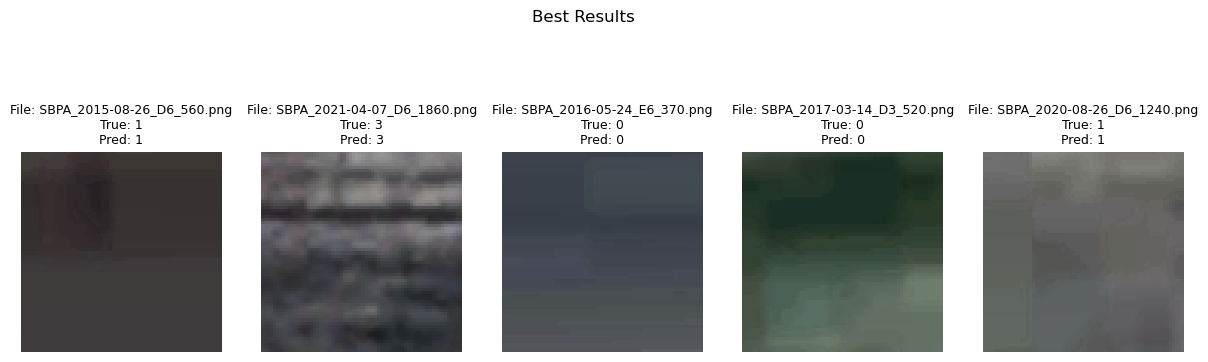

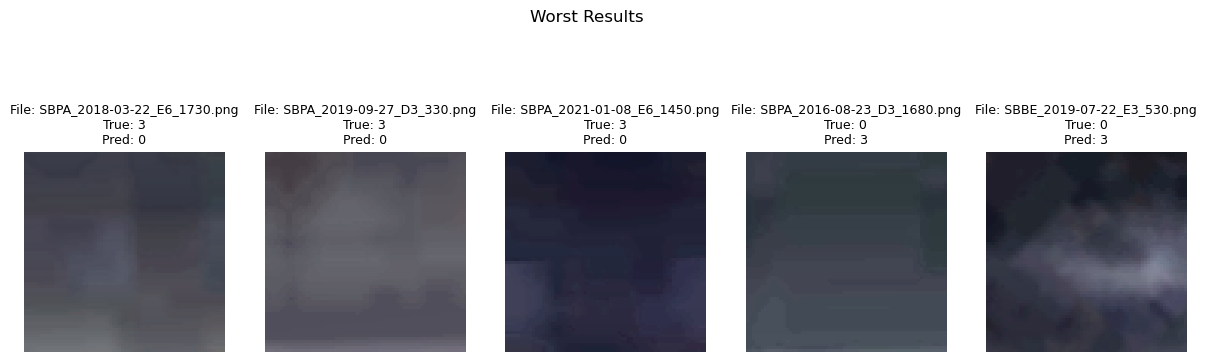

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained model, 'X_test' is your test set,
# 'y_test' are the true labels, and 'filenames_test' are the corresponding filenames.
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate individual losses (using absolute difference for simplicity)
losses = np.abs(y_test - y_pred_classes)

# Get the indices of the 5 largest and 5 smallest errors
worst_indices = np.argsort(losses)[-5:]
best_indices = np.argsort(losses)[:5]

# Ensure 'filenames_test' is a numpy array for advanced indexing
filenames_test_array = np.array(filenames_test)

# Use 'best_indices' and 'worst_indices' to directly access the corresponding filenames
best_filenames = filenames_test_array[best_indices]
worst_filenames = filenames_test_array[worst_indices]

# Update the 'plot_results' function to use the filtered filenames
def plot_results(indices, images, true_labels, pred_labels, filenames, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')  # Adjust cmap if images are not grayscale
        plt.title(f"File: {filenames[i]}\nTrue: {true_labels[idx]}\nPred: {pred_labels[idx]}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot the five best results with the correct filenames
plot_results(best_indices, X_test, y_test, y_pred_classes, best_filenames, "Best Results")

# Plot the five worst results with the correct filenames
plot_results(worst_indices, X_test, y_test, y_pred_classes, worst_filenames, "Worst Results")


172/172 [==============================] - 2s 9ms/step


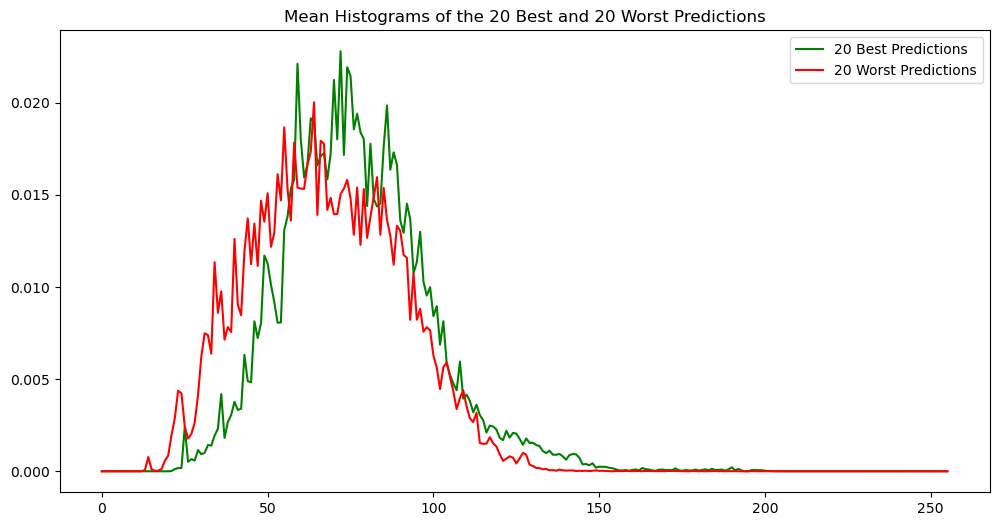

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assumindo que 'best_model' é o seu modelo treinado, 'X_test' é o seu conjunto de teste,
# e 'y_test' são os rótulos verdadeiros.

# Realizar previsões no conjunto de teste
y_pred = model.predict(X_test)

# Converter as previsões de probabilidades para rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular a "perda" como a diferença entre os rótulos verdadeiros e previstos
losses = np.abs(y_test - y_pred_classes)

# Ordenar as perdas e identificar os índices das 20 melhores e 20 piores previsões
sorted_indices = np.argsort(losses)
best_indices = sorted_indices[:20]
worst_indices = sorted_indices[-20:]

def calculate_mean_histogram(images):
    histograms = [np.histogram(image.ravel(), bins=256, range=(0, 1))[0] for image in images]
    mean_histogram = np.mean(histograms, axis=0)
    return mean_histogram / mean_histogram.sum()  # Normalizar o histograma

# Selecionar as 20 melhores e 20 piores imagens com base nos índices identificados
best_images = X_test[best_indices]
worst_images = X_test[worst_indices]

# Calcular os histogramas médios para os dois conjuntos de imagens
mean_histogram_best = calculate_mean_histogram(best_images)
mean_histogram_worst = calculate_mean_histogram(worst_images)

# Plotar os histogramas médios no mesmo gráfico
plt.figure(figsize=(12, 6))
plt.plot(mean_histogram_best, color='green', label='20 Best Predictions')
plt.plot(mean_histogram_worst, color='red', label='20 Worst Predictions')
plt.title('Mean Histograms of the 20 Best and 20 Worst Predictions')
plt.legend()
plt.show()


## SALVANDO O MODELO

In [13]:
# Salvar o modelo no formato HDF5
model.save('meu_modelo_80.h5')

# Salvar o modelo no formato SavedModel
model.save('meu_modelo_80')


C:\Users\silve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: meu_modelo_80\assets


INFO:tensorflow:Assets written to: meu_modelo_80\assets
